In [13]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.decomposition import PCA

In [14]:

import pandas as pd

# Load the CSV file into a pandas DataFrame.
df = pd.read_csv('/content/2017 NSCH_Topical_CAHMI_DRCv2.csv')

# Print detailed information about each column, including data types.
for col in df.columns:
    print(f"Column: {col}")
    print(f"  Data Type: {df[col].dtype}")
    print(f"  Unique Values: {df[col].nunique()}")
    print(f"  Missing Values: {df[col].isnull().sum()}")
    #print(f"  First 5 Values: {df[col].head()}")
    print("-" * 20)

<ipython-input-14-05a96da10478>:4: DtypeWarning: Columns (695,768) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/2017 NSCH_Topical_CAHMI_DRCv2.csv')


Column: HHID
  Data Type: int64
  Unique Values: 21599
  Missing Values: 0
--------------------
Column: FIPSST
  Data Type: int64
  Unique Values: 51
  Missing Values: 0
--------------------
Column: STRATUM
  Data Type: int64
  Unique Values: 2
  Missing Values: 0
--------------------
Column: FORMTYPE
  Data Type: int64
  Unique Values: 3
  Missing Values: 0
--------------------
Column: TOTKIDS_R
  Data Type: int64
  Unique Values: 4
  Missing Values: 0
--------------------
Column: HHLANGUAGE
  Data Type: int64
  Unique Values: 4
  Missing Values: 0
--------------------
Column: SC_AGE_YEARS
  Data Type: int64
  Unique Values: 18
  Missing Values: 0
--------------------
Column: SC_SEX
  Data Type: int64
  Unique Values: 2
  Missing Values: 0
--------------------
Column: K2Q35A_1_YEARS
  Data Type: int64
  Unique Values: 16
  Missing Values: 0
--------------------
Column: MOMAGE
  Data Type: int64
  Unique Values: 29
  Missing Values: 0
--------------------
Column: K6Q41R_STILL
  Data Ty

In [15]:


###############################################################
# SECTION 1: DATA LOADING AND PREPROCESSING
###############################################################

def load_data(data_path):
    """Load the dataset and print initial info."""
    df = pd.read_csv(data_path, low_memory=False)
    print("Initial Dataset Shape:", df.shape)
    print("\nFirst 5 Rows:")
    print(df.head())
    print("\nData Info:")
    print(df.info())
    return df

def define_outcome(df):
    """Define the outcome variable based on ADHD_17.
       Adjust this logic depending on your chosen outcome."""
    # Check unique values of ADHD_17
    print("\nUnique values in ADHD_17 before processing:", df['ADHD_17'].unique())

    # Drop invalid codes (e.g., 95,99)
    df_clean = df[~df['ADHD_17'].isin([95,99])].copy()
    print("\nDataset Shape after dropping ADHD_17 invalid codes:", df_clean.shape)

    # Map 1->0 (No ADHD), 2->1 and 3->1 (ADHD)
    df_clean.loc[:, 'ADHD_outcome'] = df_clean['ADHD_17'].map({1:0, 2:1, 3:1})

    print("\nOutcome distribution after mapping:")
    print(df_clean['ADHD_outcome'].value_counts())

    return df_clean

def select_variables(df):
    """Select outcome and predictor variables."""
    predictor_vars = [
        'SC_AGE_YEARS', 'SC_SEX', 'SC_RACE_R', 'SC_HISPANIC_R', 'povlev4_17',
        'FAMCOUNT', 'MealTogether_17', 'readto_17', 'smoking_17', 'SC_CSHCN',
        'anxiety_17', 'depress_17', 'learning_17', 'ADHDSev_17', 'PHYSACTIV',
        'BMI4_17', 'WgtConcn_17', 'TVwatch_17', 'MentHCare_17', 'IntDisab_17',
        'OthrMent_17'
    ]
    all_cols = ['ADHD_outcome'] + predictor_vars
    data = df[all_cols].copy()

    print("\nSelected Variables:")
    print(data.columns.tolist())

    # Check for missing values
    missing_counts = data.isnull().sum()
    print("\nMissing values per selected column:")
    print(missing_counts)

    # Drop rows with any missing values
    data_clean = data.dropna(subset=all_cols)
    print("\nData shape after dropping missing values:", data_clean.shape)

    return data_clean, predictor_vars

###############################################################
# SECTION 2: EXPLORATORY DATA ANALYSIS (EDA)
# Create at least 10 unique and creative EDA plots
###############################################################

def plot_eda(data, predictor_vars):
    """Perform EDA with diverse and high-definition plots."""

    # Set Seaborn theme for better aesthetics
    sns.set_theme(style="whitegrid")

    # ADHD outcome palette (2 categories: No ADHD=0, ADHD=1)
    adhd_palette = ['#1f77b4', '#ff7f0e']  # Blue for No ADHD, Orange for ADHD

    # 1. Distribution of SC_AGE_YEARS (Histogram with KDE)
    plt.figure(figsize=(10,6))
    sns.histplot(data['SC_AGE_YEARS'], bins=20, kde=True, color='#4682B4', edgecolor='black')
    plt.title('Distribution of Child Age (Years)', fontsize=16)
    plt.xlabel('Age (Years)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # 2. Count plot of ADHD_outcome with percentage annotations (single color)
    plt.figure(figsize=(8,6))
    ax = sns.countplot(x='ADHD_outcome', data=data, color='#4c72b0')
    plt.title('ADHD Outcome Distribution', fontsize=16)
    plt.xlabel('ADHD Outcome (0 = No, 1 = Yes)', fontsize=14)
    plt.ylabel('Count', fontsize=14)

    total = len(data)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(percentage, (x + width/2, y + height + total*0.01), ha='center', fontsize=12)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # 3. Bar plot showing ADHD_outcome rate by SC_SEX (single color)
    plt.figure(figsize=(10,6))
    sex_rate = data.groupby('SC_SEX')['ADHD_outcome'].mean().reset_index()
    sex_mapping = {1: 'Male', 2: 'Female', 3: 'Other'}
    sex_rate['Sex'] = sex_rate['SC_SEX'].map(sex_mapping)

    ax = sns.barplot(x='Sex', y='ADHD_outcome', data=sex_rate, color='#4c72b0')
    plt.title('ADHD Outcome Rate by Sex', fontsize=16)
    plt.xlabel('Sex', fontsize=14)
    plt.ylabel('Proportion with ADHD', fontsize=14)
    plt.ylim(0,1)

    for index, row_ in sex_rate.iterrows():
        plt.text(index, row_['ADHD_outcome']+0.02, f"{row_['ADHD_outcome']:.2f}", color='black', ha="center", fontsize=12)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # 4. Bar plot showing ADHD_outcome rate by SC_RACE_R (single color)
    plt.figure(figsize=(12,7))
    race_rate = data.groupby('SC_RACE_R')['ADHD_outcome'].mean().reset_index()
    race_mapping = {
        1: 'White',
        2: 'Black',
        3: 'Asian',
        4: 'Hispanic',
        5: 'Other'
    }
    race_rate['Race'] = race_rate['SC_RACE_R'].map(race_mapping)

    ax = sns.barplot(x='Race', y='ADHD_outcome', data=race_rate, color='#4c72b0')
    plt.title('ADHD Outcome Rate by Race', fontsize=16)
    plt.xlabel('Race', fontsize=14)
    plt.ylabel('Proportion with ADHD', fontsize=14)
    plt.ylim(0,1)

    for index, row_ in race_rate.iterrows():
        plt.text(index, row_['ADHD_outcome']+0.02, f"{row_['ADHD_outcome']:.2f}", color='black', ha="center", fontsize=12)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # 5. Boxplot of SC_AGE_YEARS by ADHD_outcome (single color)
    plt.figure(figsize=(10,6))
    sns.boxplot(x='ADHD_outcome', y='SC_AGE_YEARS', data=data, color='#4c72b0')
    plt.title('Age Distribution by ADHD Outcome', fontsize=16)
    plt.xlabel('ADHD Outcome (0 = No, 1 = Yes)', fontsize=14)
    plt.ylabel('Age (Years)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # 6. Violin plot of SC_AGE_YEARS by ADHD_outcome (single color)
    plt.figure(figsize=(10,6))
    sns.violinplot(x='ADHD_outcome', y='SC_AGE_YEARS', data=data, color='#4c72b0', inner='quartile')
    plt.title('Age Distribution by ADHD Outcome (Violin Plot)', fontsize=16)
    plt.xlabel('ADHD Outcome (0 = No, 1 = Yes)', fontsize=14)
    plt.ylabel('Age (Years)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # 7. Stacked bar plot (using pandas) for ADHD_outcome by anxiety_17
    plt.figure(figsize=(12,7))
    anxiety_ct = pd.crosstab(data['anxiety_17'], data['ADHD_outcome'])
    anxiety_ct.columns = ['No ADHD', 'ADHD']
    anxiety_ct.index = anxiety_ct.index.map({0: 'No Anxiety', 1: 'Anxiety'})
    anxiety_ct.plot(kind='bar', stacked=True, color=['#66b3ff','#ff9999'], edgecolor='black')
    plt.title('ADHD Outcome by Anxiety Status', fontsize=16)
    plt.xlabel('Anxiety Status', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title='ADHD Outcome', fontsize=12, title_fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # 8. Correlation heatmap
    plt.figure(figsize=(12,10))
    corr_subset = data[predictor_vars[:10]].corr()
    sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 12})
    plt.title('Correlation Heatmap of First 10 Predictors', fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

    # 9. Cumulative distribution plot of SC_AGE_YEARS
    plt.figure(figsize=(10,6))
    sorted_ages = np.sort(data['SC_AGE_YEARS'])
    cdf = np.arange(len(sorted_ages))/len(sorted_ages)
    plt.plot(sorted_ages, cdf, color='darkgreen', linewidth=2)
    plt.fill_between(sorted_ages, cdf, color='lightgreen', alpha=0.5)
    plt.title('Cumulative Distribution of Child Age', fontsize=16)
    plt.xlabel('Age (Years)', fontsize=14)
    plt.ylabel('Cumulative Probability', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 10. Scatter plot (jittered) for SC_AGE_YEARS vs TVwatch_17 (no hue)
    jittered_age = data['SC_AGE_YEARS'] + np.random.normal(0,0.1,size=len(data))
    jittered_tv = data['TVwatch_17'] + np.random.normal(0,0.1,size=len(data))
    plt.figure(figsize=(10,6))
    plt.scatter(jittered_age, jittered_tv, c='#4c72b0', alpha=0.6, edgecolor=None)
    plt.title('Age vs TV Watching Hours (Jittered)', fontsize=16)
    plt.xlabel('Age (Years)', fontsize=14)
    plt.ylabel('TV Watching Hours per Day', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 11. KDE plot of SC_AGE_YEARS by outcome with hue
    plt.figure(figsize=(10,6))
    sns.kdeplot(data=data, x='SC_AGE_YEARS', hue='ADHD_outcome', fill=True, palette=adhd_palette, alpha=0.5)
    plt.title('Age Distribution by ADHD Outcome (KDE)', fontsize=16)
    plt.xlabel('Age (Years)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(title='ADHD Outcome', labels=['No ADHD', 'ADHD'], title_fontsize=14, fontsize=12)
    plt.tight_layout()
    plt.show()

    # 12. Joint plot (Scatter + Hexbin) for SC_AGE_YEARS vs readto_17
    g = sns.jointplot(data=data, x='SC_AGE_YEARS', y='readto_17', kind='hex', color='#FF6666', height=8)
    g.fig.suptitle('Joint Distribution of Age and Reading Frequency', y=1.02, fontsize=16)
    plt.xlabel('Age (Years)', fontsize=14)
    plt.ylabel('Days Read To Child per Week', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 13. Pairplot with hue for ADHD_outcome
    subset_vars = ['SC_AGE_YEARS', 'TVwatch_17', 'readto_17', 'ADHD_outcome']
    sns.pairplot(data[subset_vars], hue='ADHD_outcome', palette=adhd_palette, diag_kind='kde', markers=["o", "s"], height=3)
    plt.suptitle('Pairwise Relationships among Selected Variables', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

    # 14. Rug plot + KDE overlay for SC_AGE_YEARS for ADHD=1 only
    plt.figure(figsize=(10,6))
    sns.kdeplot(data=data[data['ADHD_outcome']==1], x='SC_AGE_YEARS', fill=True, color='#ff9999', alpha=0.5)
    sns.rugplot(data=data[data['ADHD_outcome']==1], x='SC_AGE_YEARS', height=0.05, color='red')
    plt.title('Age Distribution Rug Plot for ADHD Cases Only', fontsize=16)
    plt.xlabel('Age (Years)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 15. PCA for dimensionality reduction (2D) with hue for ADHD_outcome
    X = data[predictor_vars].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data['ADHD_outcome'], palette=adhd_palette, alpha=0.6)
    plt.title('PCA Visualization of Predictors Colored by ADHD Outcome', fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=14)
    plt.ylabel('Principal Component 2', fontsize=14)
    plt.legend(title='ADHD Outcome', title_fontsize=14, fontsize=12)
    plt.tight_layout()
    plt.show()

###############################################################
# SECTION 3: MODELING
###############################################################

def train_models(data, predictor_vars):
    """Train Logistic Regression, Random Forest, and Gradient Boosting models."""
    X = data[predictor_vars]
    y = data['ADHD_outcome']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    # Logistic Regression
    log_reg = LogisticRegression(max_iter=1000, random_state=42)
    log_reg.fit(X_train, y_train)
    y_pred_lr = log_reg.predict(X_test)
    y_pred_prob_lr = log_reg.predict_proba(X_test)[:,1]

    # Random Forest
    rf = RandomForestClassifier(random_state=42, n_estimators=100)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    y_pred_prob_rf = rf.predict_proba(X_test)[:,1]

    # Gradient Boosting
    gb = GradientBoostingClassifier(random_state=42, n_estimators=100)
    gb.fit(X_train, y_train)
    y_pred_gb = gb.predict(X_test)
    y_pred_prob_gb = gb.predict_proba(X_test)[:,1]

    return (log_reg, (y_test, y_pred_lr, y_pred_prob_lr),
            rf, (y_test, y_pred_rf, y_pred_prob_rf),
            gb, (y_test, y_pred_gb, y_pred_prob_gb), X_train, X_test, y_train, y_test)

###############################################################
# SECTION 4: MODEL EVALUATION AND PLOTTING
###############################################################

def evaluate_model(name, y_test, y_pred, y_pred_prob):
    """Evaluate the model and plot confusion matrix and ROC curve."""
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.3f}")
    print(f"AUC: {auc:.3f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No ADHD', 'ADHD'], yticklabels=['No ADHD', 'ADHD'])
    plt.title(f'Confusion Matrix: {name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.tight_layout()
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_pred_prob, name=name)
    plt.title(f'ROC Curve: {name}', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_feature_importances(model, predictor_vars, top_n=20):
    """Plot feature importances from a Random Forest or Gradient Boosting model."""
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=predictor_vars).sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feat_imp)

    plt.figure(figsize=(10,8))
    sns.barplot(x=feat_imp.values[:top_n], y=feat_imp.index[:top_n], color='#4c72b0')
    plt.title(f'Top {top_n} Feature Importances', fontsize=16)
    plt.xlabel('Importance Score', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.tight_layout()
    plt.show()

###############################################################
# SECTION 5: SAVING OUTPUTS (Final Dataset and Data Dictionary)
###############################################################

def save_outputs(data, predictor_vars):
    """Save the final analyzed dataset and a comprehensive data dictionary with hardcoded descriptions."""
    # Save final analyzed dataset
    data.to_csv('final_analyzed_dataset.csv', index=False)
    print("\nFinal analyzed dataset saved as 'final_analyzed_dataset.csv'.")

    # Hardcoded Data Dictionary
    data_dictionary = pd.DataFrame({
        'Variable': ['ADHD_outcome'] + predictor_vars,
        'Data_Type': [str(data[col].dtype) for col in ['ADHD_outcome']+predictor_vars],
        'Description': [
            'ADHD outcome (0 = No ADHD, 1 = ADHD present based on ADHD_17 values)',
            'Age of the child in years',
            'Sex of the child (1 = Male, 2 = Female, 3 = Other)',
            'Race of the child (coded numerically; e.g., 1=White, 2=Black, 3=Asian, etc.)',
            'Hispanic origin of the child (1 = Yes, 2 = No)',
            'Poverty level indicator for the child’s family in 2017 (1=Below Poverty, 2=At/Above)',
            'Number of family members in the household',
            'Frequency of family meals together in 2017 (1=Never,2=Rarely,3=Sometimes,4=Often,5=Always)',
            'Number of days parents read to the child per week (0 to 7)',
            'Household smoking environment indicator (1=Yes,2=No)',
            'Child special health care needs status (1=Yes,2=No)',
            'Presence of anxiety in the child (0=No,1=Yes)',
            'Presence of depression in the child (0=No,1=Yes)',
            'Presence of learning disability in the child (0=No,1=Yes)',
            'ADHD severity indicator (1=Mild,2=Moderate,3=Severe)',
            'Level of physical activity (1=Inactive,...,5=Very Active)',
            'BMI category (1=Underweight,2=Normal,3=Overweight,4=Obese)',
            'Parental concern about child’s weight (1=Not Concerned,...,5=Extremely Concerned)',
            'Average TV watching hours per day (0 to 24)',
            'Whether child received needed mental health care (1=Yes,2=No)',
            'Presence of intellectual disability (0=No,1=Yes)',
            'Presence of other mental health conditions (0=No,1=Yes)'
        ],
        'Value_Range_or_Categories': [
            '0, 1',
            '0 to 17',
            '1=Male,2=Female,3=Other',
            'e.g.,1=White,2=Black,3=Asian,...',
            '1=Yes,2=No',
            '1=Below Poverty,2=At/Above Poverty',
            'Numeric range: [1,10+]',
            '1=Never,...,5=Always',
            '0 to 7 days',
            '1=Yes,2=No',
            '1=Yes,2=No',
            '0,1',
            '0,1',
            '0,1',
            '1=Mild,2=Moderate,3=Severe',
            '1=Inactive,...,5=Very Active',
            '1=Underweight,...,4=Obese',
            '1=Not Concerned,...,5=Extremely Concerned',
            '0 to 24 hours',
            '1=Yes,2=No',
            '0,1',
            '0,1'
        ]
    })

    # Save data dictionary
    data_dictionary.to_csv('data_dictionary.csv', index=False)
    print("Data dictionary saved as 'data_dictionary.csv'.")



In [16]:
###############################################################
# SECTION 6: MAIN EXECUTION
###############################################################
data_path = '2017 NSCH_Topical_CAHMI_DRCv2.csv'  # Adjust if needed
df = load_data(data_path)
df = define_outcome(df)
data, predictor_vars = select_variables(df)


Initial Dataset Shape: (21599, 813)

First 5 Rows:
       HHID  FIPSST  STRATUM  FORMTYPE  TOTKIDS_R  HHLANGUAGE  SC_AGE_YEARS  \
0  17000010      37        1         1          3           3             0   
1  17000013       2        2         3          1           1            13   
2  17000025      40        1         3          1           1            15   
3  17000031      13        1         2          1           1             9   
4  17000034      31        1         2          2           1             8   

   SC_SEX  K2Q35A_1_YEARS  MOMAGE  ...  npm15AdIns_17  BREASTFEDEND_DAY_S  \
0       2              95      36  ...              1                  98   
1       2              95      30  ...              1                  90   
2       1              13      30  ...              1                  90   
3       1              95      27  ...              1                  90   
4       2              95      27  ...              1                  90   

   BREASTFE

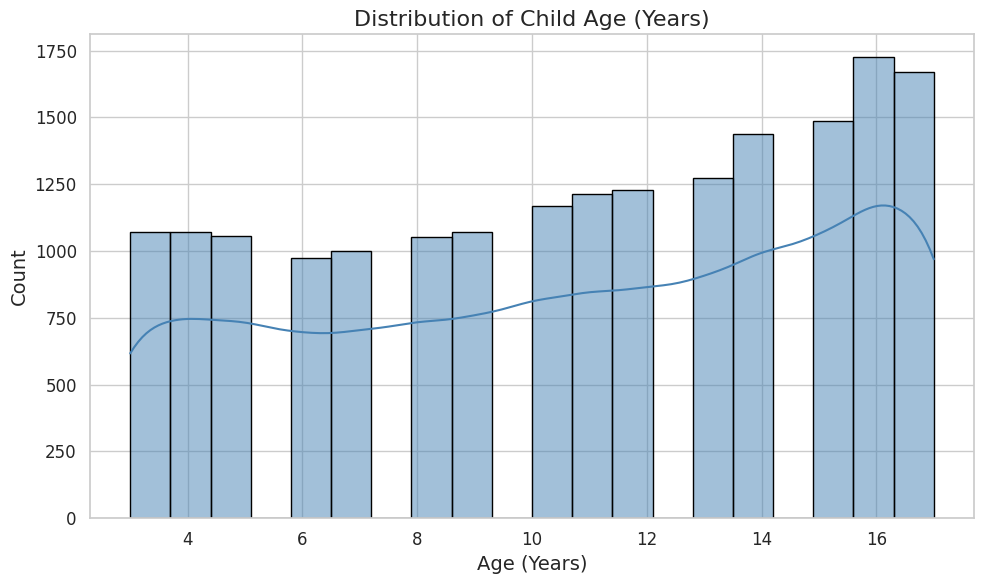

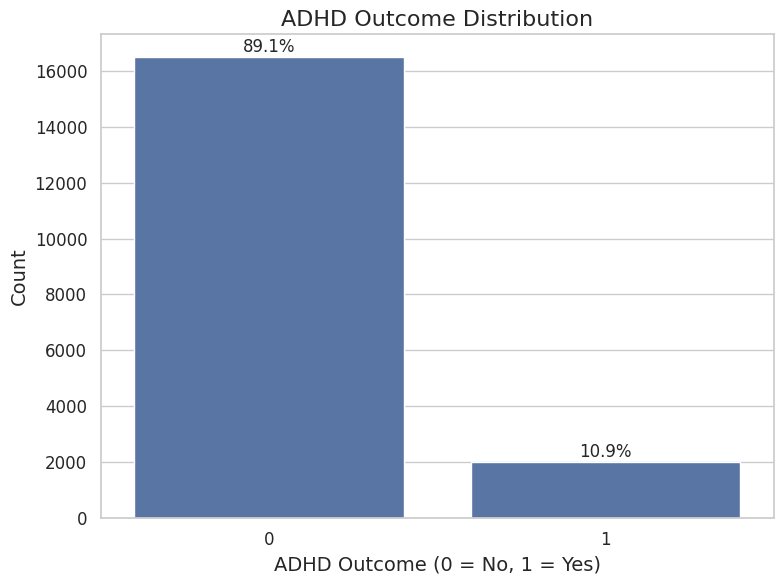

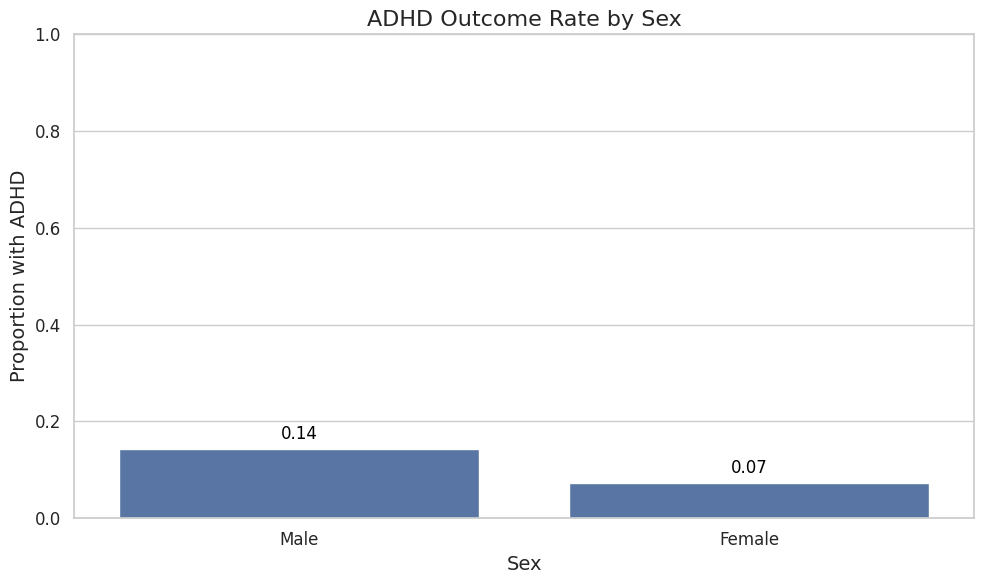

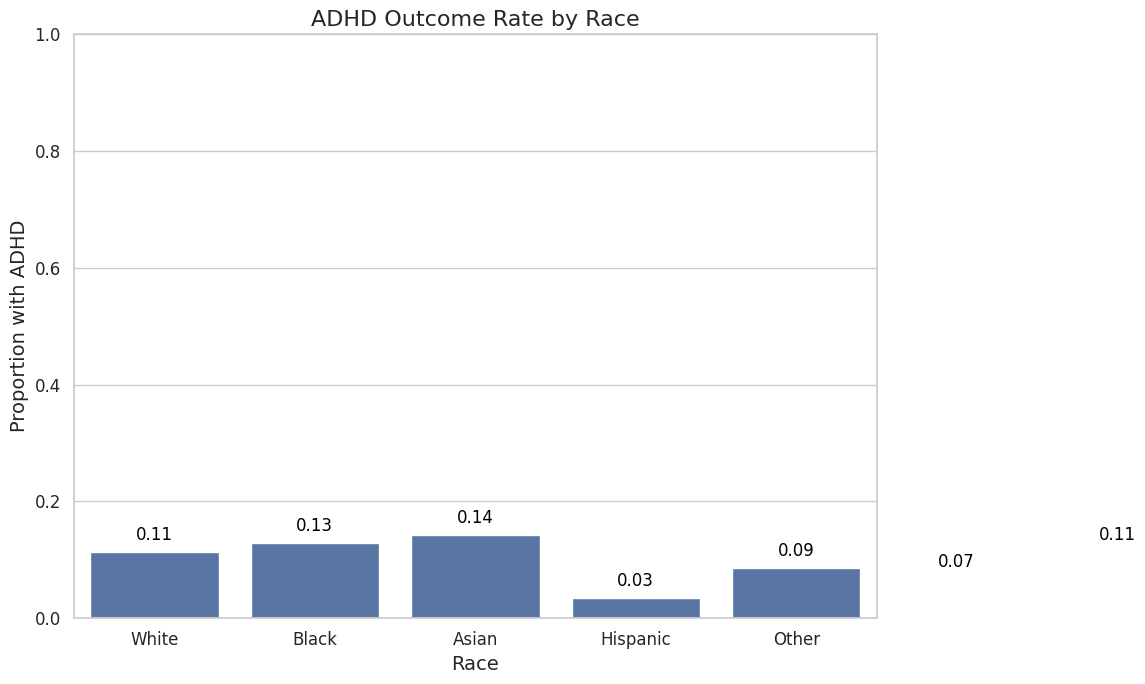

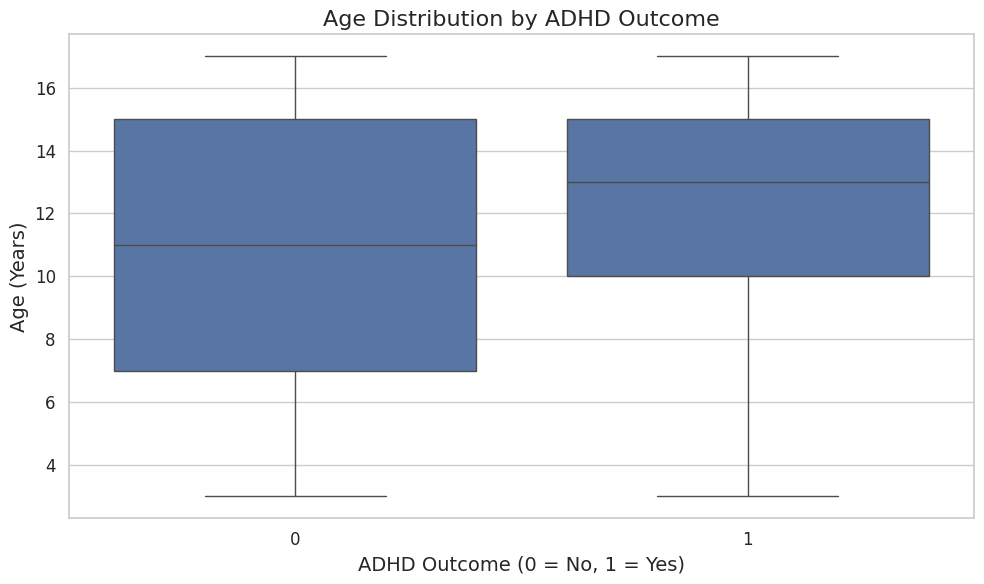

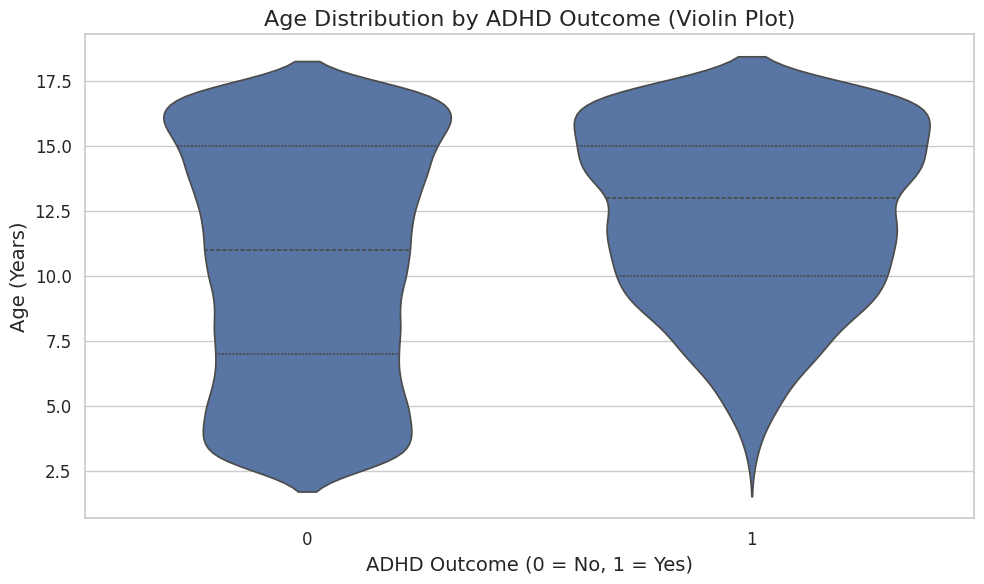

<Figure size 1200x700 with 0 Axes>

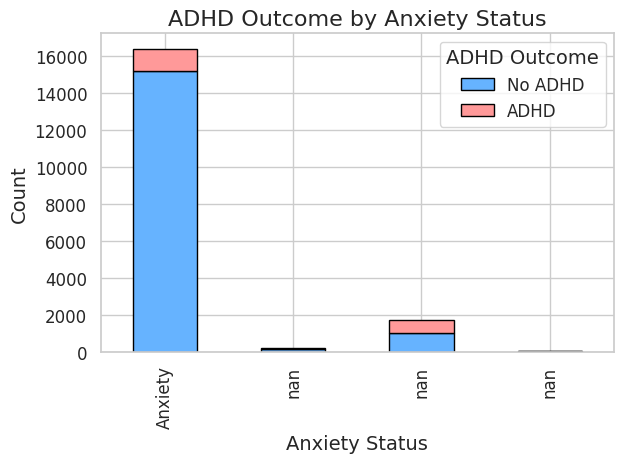

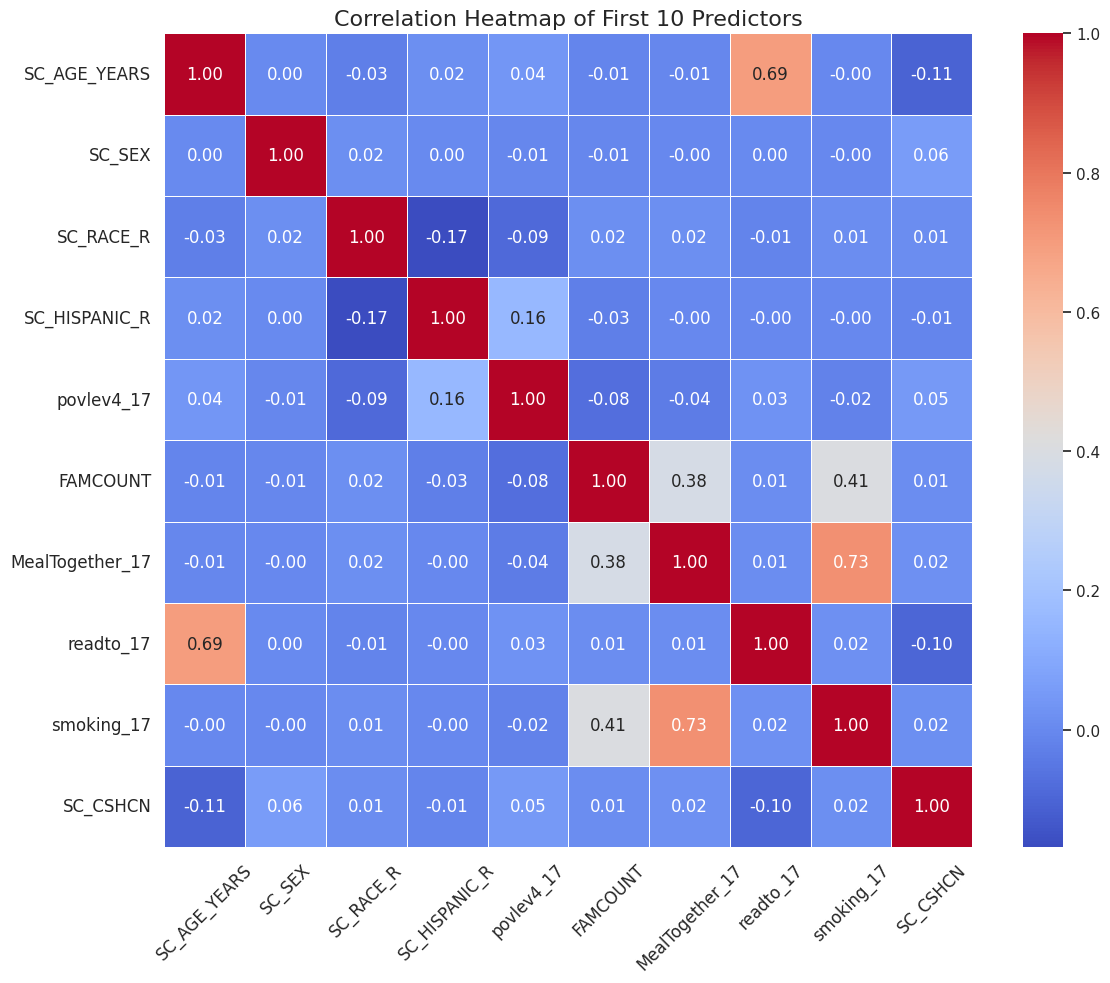

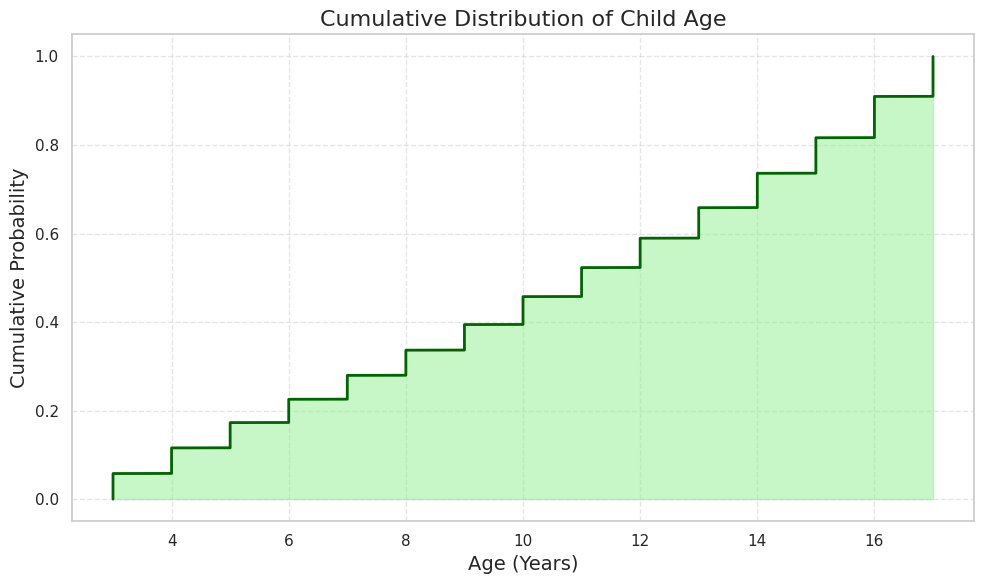

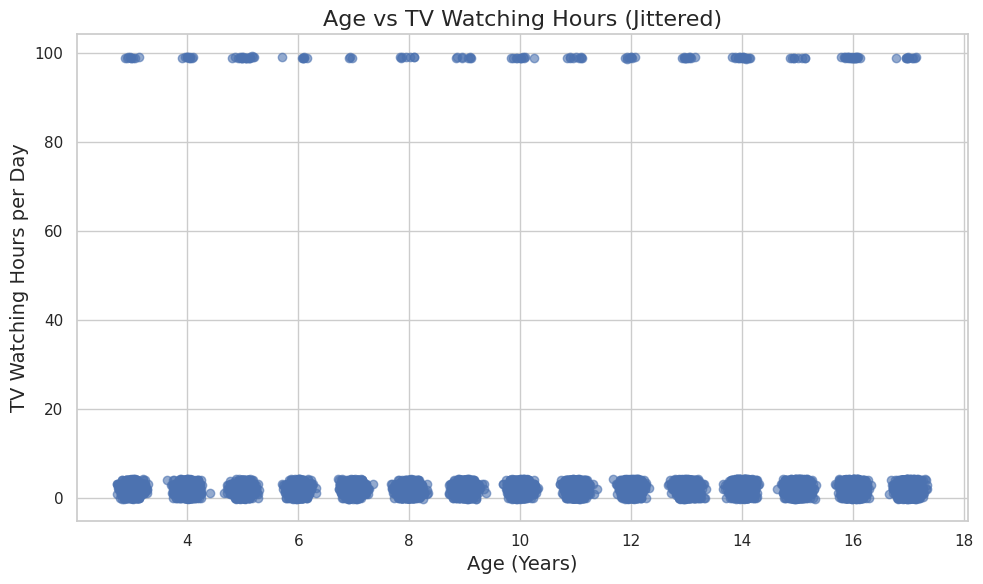

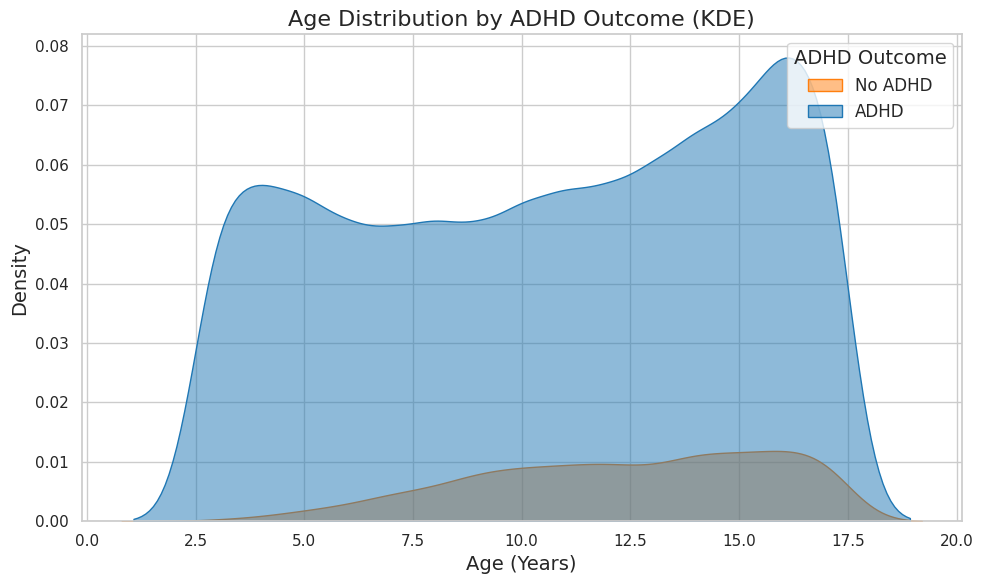

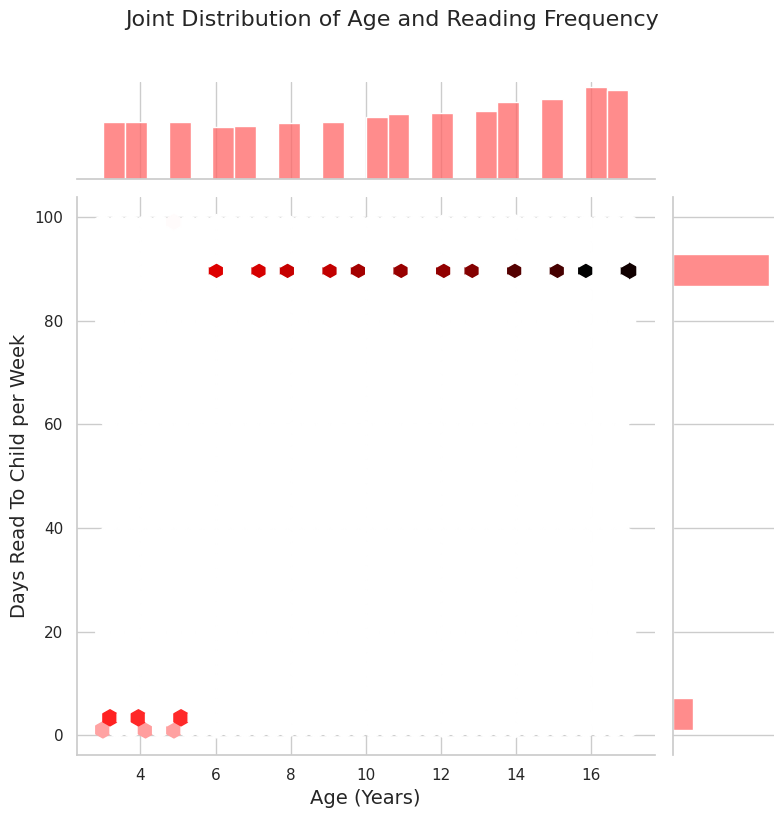

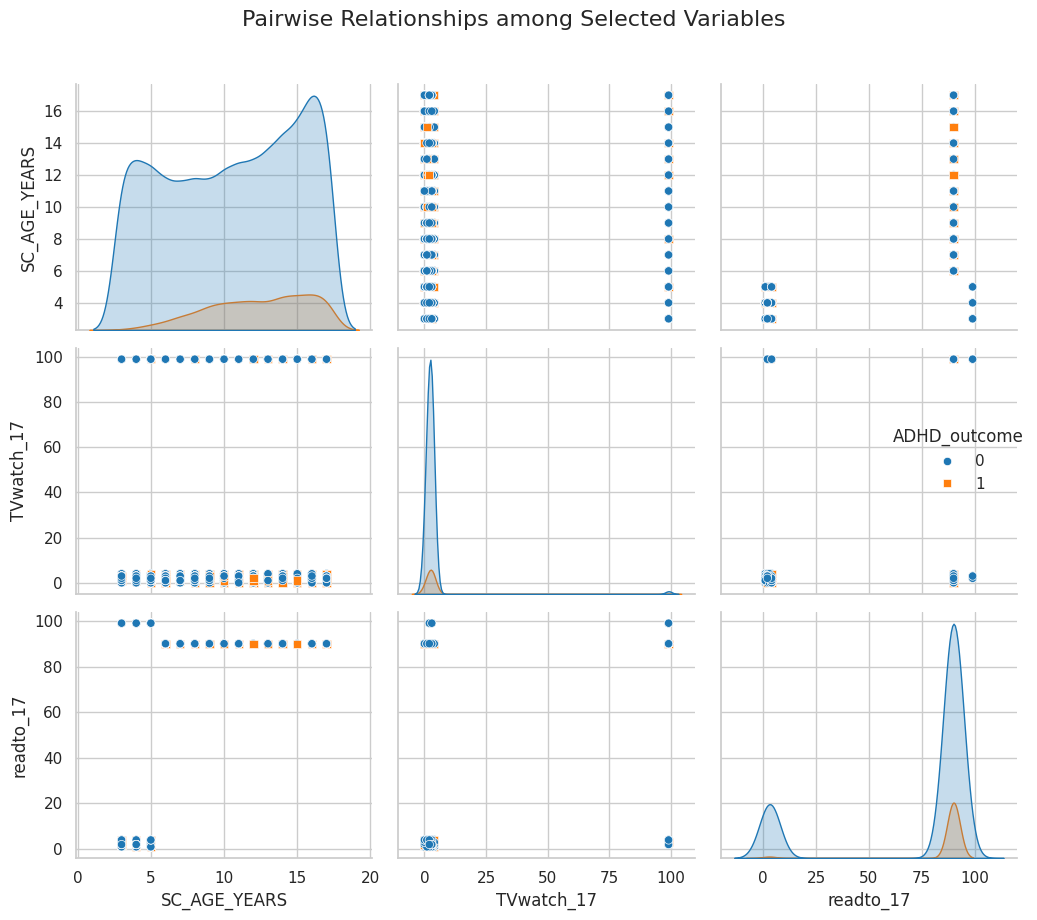

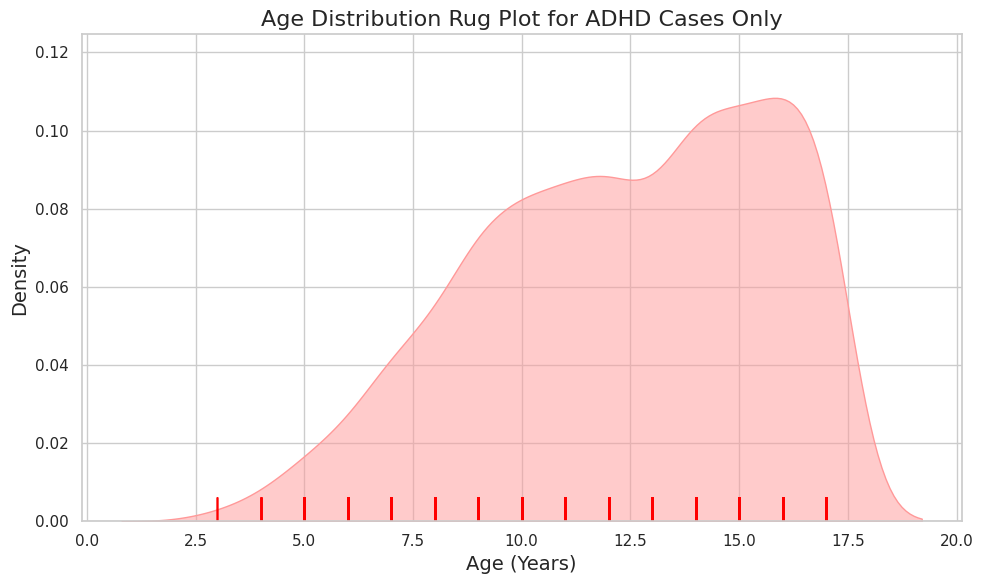

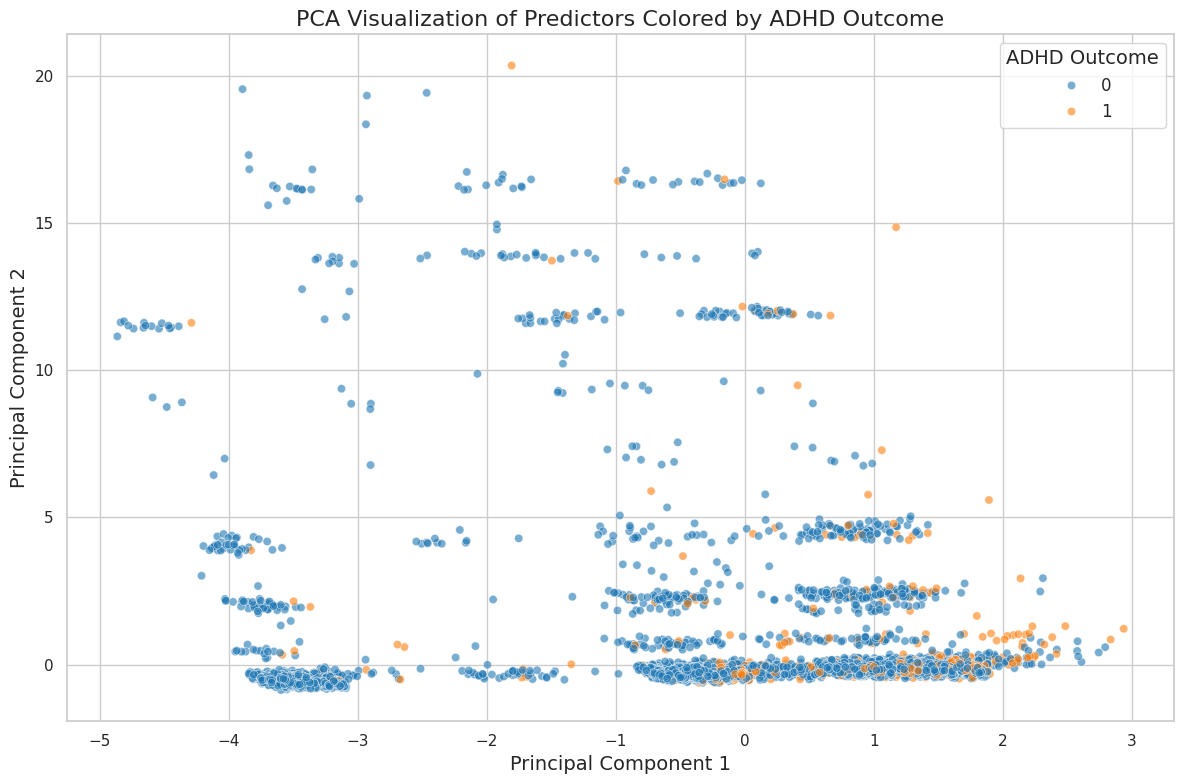

In [17]:
# Perform EDA
plot_eda(data, predictor_vars)


In [18]:
# Train models
log_reg, lr_res, rf, rf_res, gb, gb_res, X_train, X_test, y_train, y_test = train_models(data, predictor_vars)



Logistic Regression Results:
Accuracy: 0.993
AUC: 0.986
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3296
           1       1.00      0.94      0.97       404

    accuracy                           0.99      3700
   macro avg       1.00      0.97      0.98      3700
weighted avg       0.99      0.99      0.99      3700



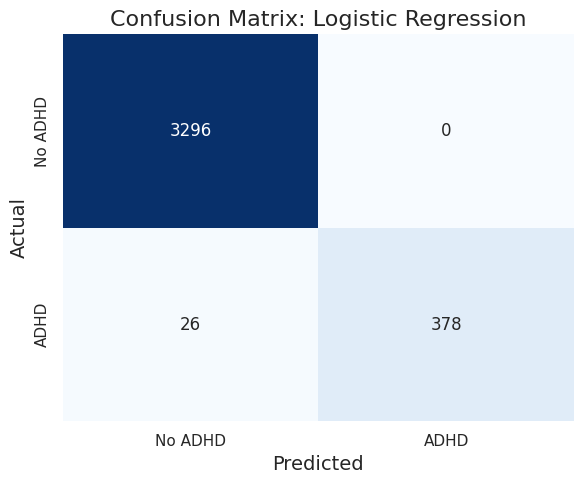

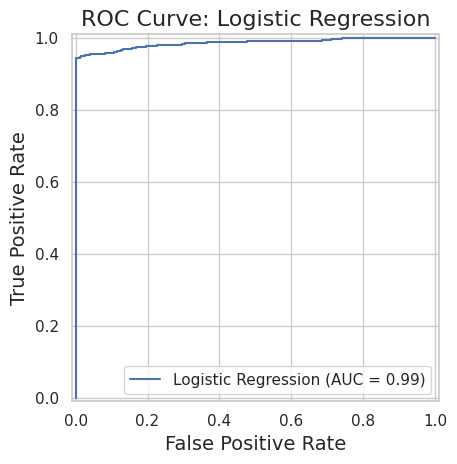

In [20]:
# Evaluate models
evaluate_model("Logistic Regression", *lr_res)


Random Forest Results:
Accuracy: 0.993
AUC: 0.984
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3296
           1       0.99      0.95      0.97       404

    accuracy                           0.99      3700
   macro avg       0.99      0.97      0.98      3700
weighted avg       0.99      0.99      0.99      3700



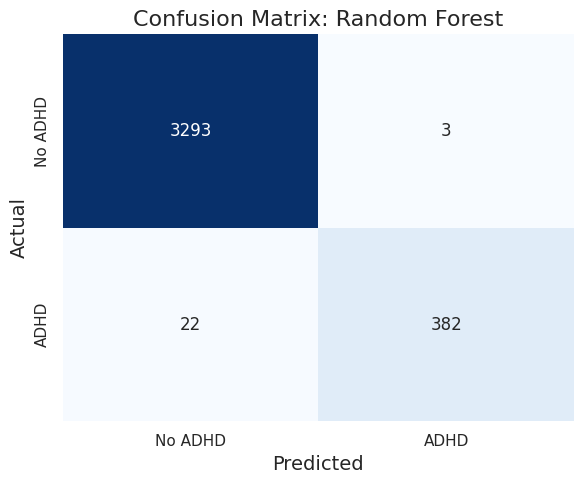

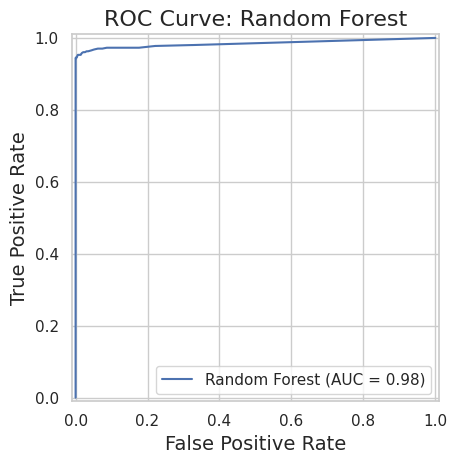

In [21]:
evaluate_model("Random Forest", *rf_res)


Gradient Boosting Results:
Accuracy: 0.993
AUC: 0.989
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3296
           1       0.98      0.95      0.97       404

    accuracy                           0.99      3700
   macro avg       0.99      0.97      0.98      3700
weighted avg       0.99      0.99      0.99      3700



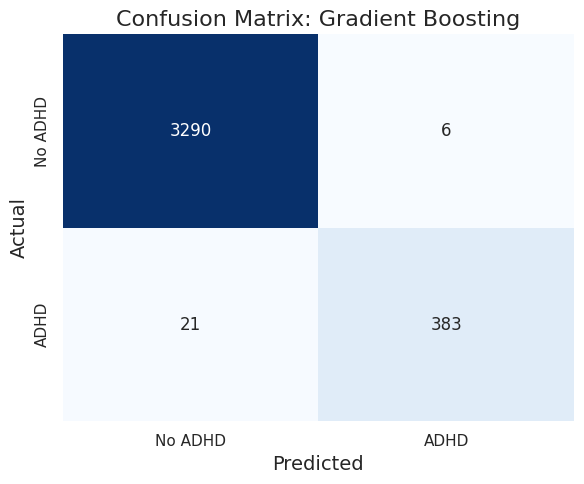

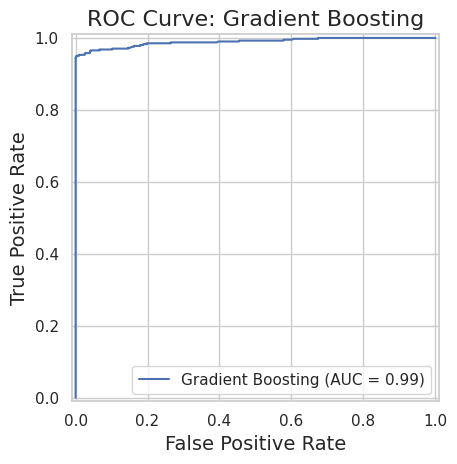

In [22]:
evaluate_model("Gradient Boosting", *gb_res)


Feature Importances:
ADHDSev_17         0.658553
SC_CSHCN           0.056654
OthrMent_17        0.056136
learning_17        0.040257
MentHCare_17       0.029411
SC_AGE_YEARS       0.023050
anxiety_17         0.017951
FAMCOUNT           0.014382
PHYSACTIV          0.013046
TVwatch_17         0.012631
MealTogether_17    0.012234
BMI4_17            0.011021
povlev4_17         0.010926
depress_17         0.009896
SC_SEX             0.008183
SC_RACE_R          0.006422
smoking_17         0.005303
WgtConcn_17        0.005050
readto_17          0.003468
SC_HISPANIC_R      0.003120
IntDisab_17        0.002303
dtype: float64


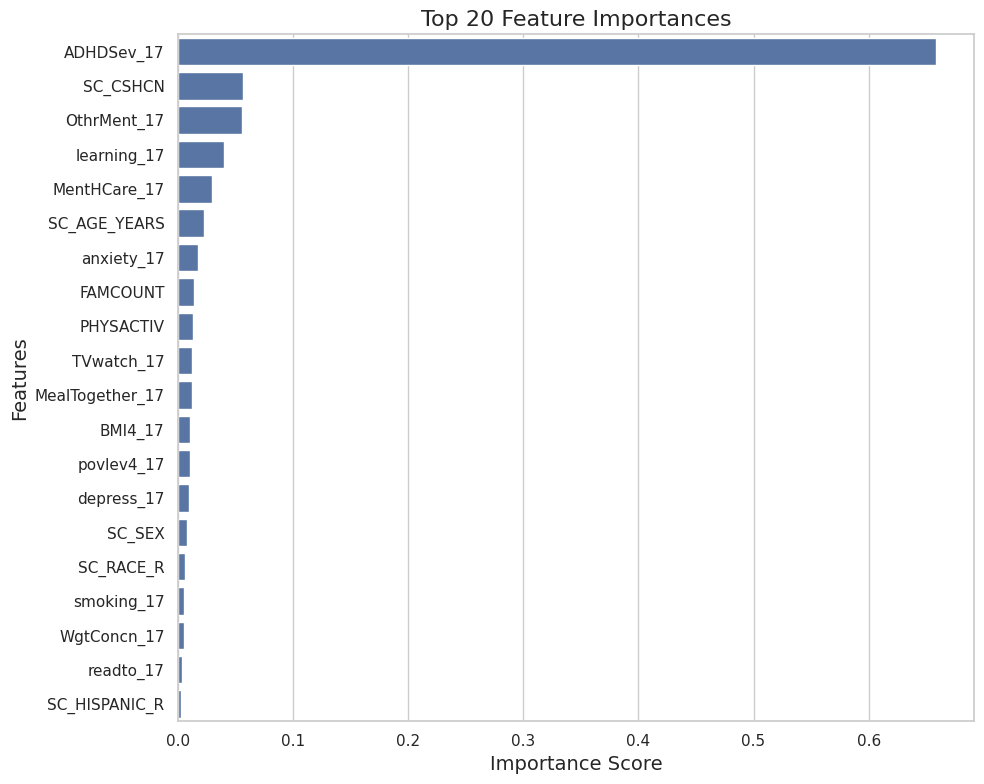

In [23]:
# Feature importance from RF
plot_feature_importances(rf, predictor_vars)

In [24]:
# Save final outputs
save_outputs(data, predictor_vars)

print("\nAnalysis complete. Check the generated plots, 'final_analyzed_dataset.csv', and 'data_dictionary.csv' for results.")



Final analyzed dataset saved as 'final_analyzed_dataset.csv'.
Data dictionary saved as 'data_dictionary.csv'.

Analysis complete. Check the generated plots, 'final_analyzed_dataset.csv', and 'data_dictionary.csv' for results.
